# Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough, don't let the data make it any harder.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

Based on [this](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
%matplotlib inline

Earlier, I fetched some data

```python
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2015_games.html")
games = tables[0]
games.to_csv('data/games.csv', index=False)
```

`read_html` is a pretty neat function.

In [3]:
!head -n 2 data/games.csv

Date,Unnamed: 1,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Notes
"Tue, Oct 28, 2014",Box Score,Houston Rockets,108,Los Angeles Lakers,90,,


The Question:
> **How many days of rest did each team get between each game?**

In [4]:
column_names = ['date', '_', 'away_team', 'away_points', 'home_team',
                'home_points', 'n_ot', 'notes']
games = (pd.read_csv('data/games.csv', names=column_names, parse_dates=['date'],
                     skiprows=1)
           .drop(['_', 'notes', 'n_ot'], axis='columns')
           .set_index('date', append=True))
            
games.index.names = ['game_id', 'date']
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108


Whether or not your dataset is tidy depends on your question. Given our question, **How many days of rest did each team get between each game?** what is an observation?

<p style="color: white;a:hover">A (date, team) pair</p>

Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row. We'll use `pd.melt` to fix that.

In [8]:
games.reset_index().head()

,game_id,date,away_team,away_points,home_team,home_points
0,0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90
1,1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101
2,2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101
3,3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121
4,4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108


In [21]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team').sort('date')

In [23]:
tidy.head()

,game_id,date,variable,team
0,0,2014-10-28,away_team,Houston Rockets
1,1,2014-10-28,away_team,Orlando Magic
2,2,2014-10-28,away_team,Dallas Mavericks
1231,1,2014-10-28,home_team,New Orleans Pelicans
1232,2,2014-10-28,home_team,San Antonio Spurs


Now, getting the answer is trivial: group by team and diff `date`.

In [28]:
import datetime

In [31]:
tidy.groupby('team')['date'].diff().dt.days

0      NaN
1      NaN
2      NaN
1231   NaN
1232   NaN
        ..
1218     1
1217     2
1216     2
2458     2
2459     1
dtype: float64

In [32]:
tidy['rest'] = tidy.groupby('team').date.diff().dt.days
tidy.dropna().head()

,game_id,date,variable,team,rest
10,10,2014-10-29,away_team,Los Angeles Lakers,1
14,14,2014-10-29,away_team,Houston Rockets,1
1248,18,2014-10-30,home_team,Minnesota Timberwolves,1
16,16,2014-10-30,away_team,Utah Jazz,1
1249,19,2014-10-30,home_team,Orlando Magic,2


In [35]:
un = pd.pivot_table(tidy, values='rest',
                    index=['game_id', 'date'],
                    columns='variable').rename(
    columns={'away_team': 'away_rest', 'home_team': 'home_rest'}
)
un.columns.name = None

In [36]:
un.dropna().head()

,,away_rest,home_rest
game_id,date,,
16,2014-10-30,1,2
18,2014-10-30,1,1
19,2014-10-30,1,2
20,2014-10-31,1,2
21,2014-10-31,2,2


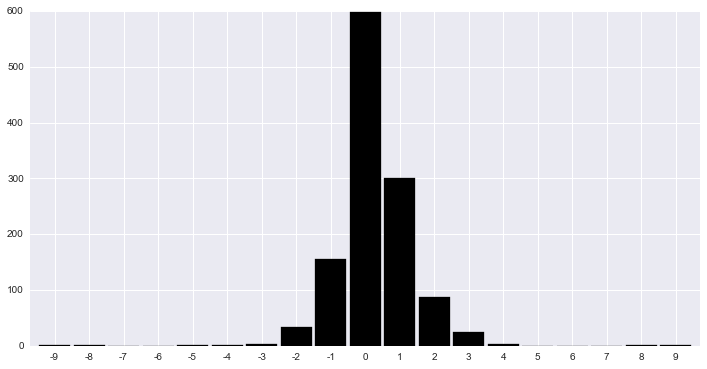

In [43]:
delta = (un.home_rest - un.away_rest).dropna().astype(int)
(delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index().plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6)))

In [45]:
tidy

,game_id,date,variable,team,rest
0,0,2014-10-28,away_team,Houston Rockets,NaN
1,1,2014-10-28,away_team,Orlando Magic,NaN
2,2,2014-10-28,away_team,Dallas Mavericks,NaN
1231,1,2014-10-28,home_team,New Orleans Pelicans,NaN
1232,2,2014-10-28,home_team,San Antonio Spurs,NaN
...,...,...,...,...,...
1218,1218,2015-04-15,away_team,Washington Wizards,1
1217,1217,2015-04-15,away_team,Atlanta Hawks,2
1216,1216,2015-04-15,away_team,Orlando Magic,2
2458,1228,2015-04-15,home_team,Philadelphia 76ers,2


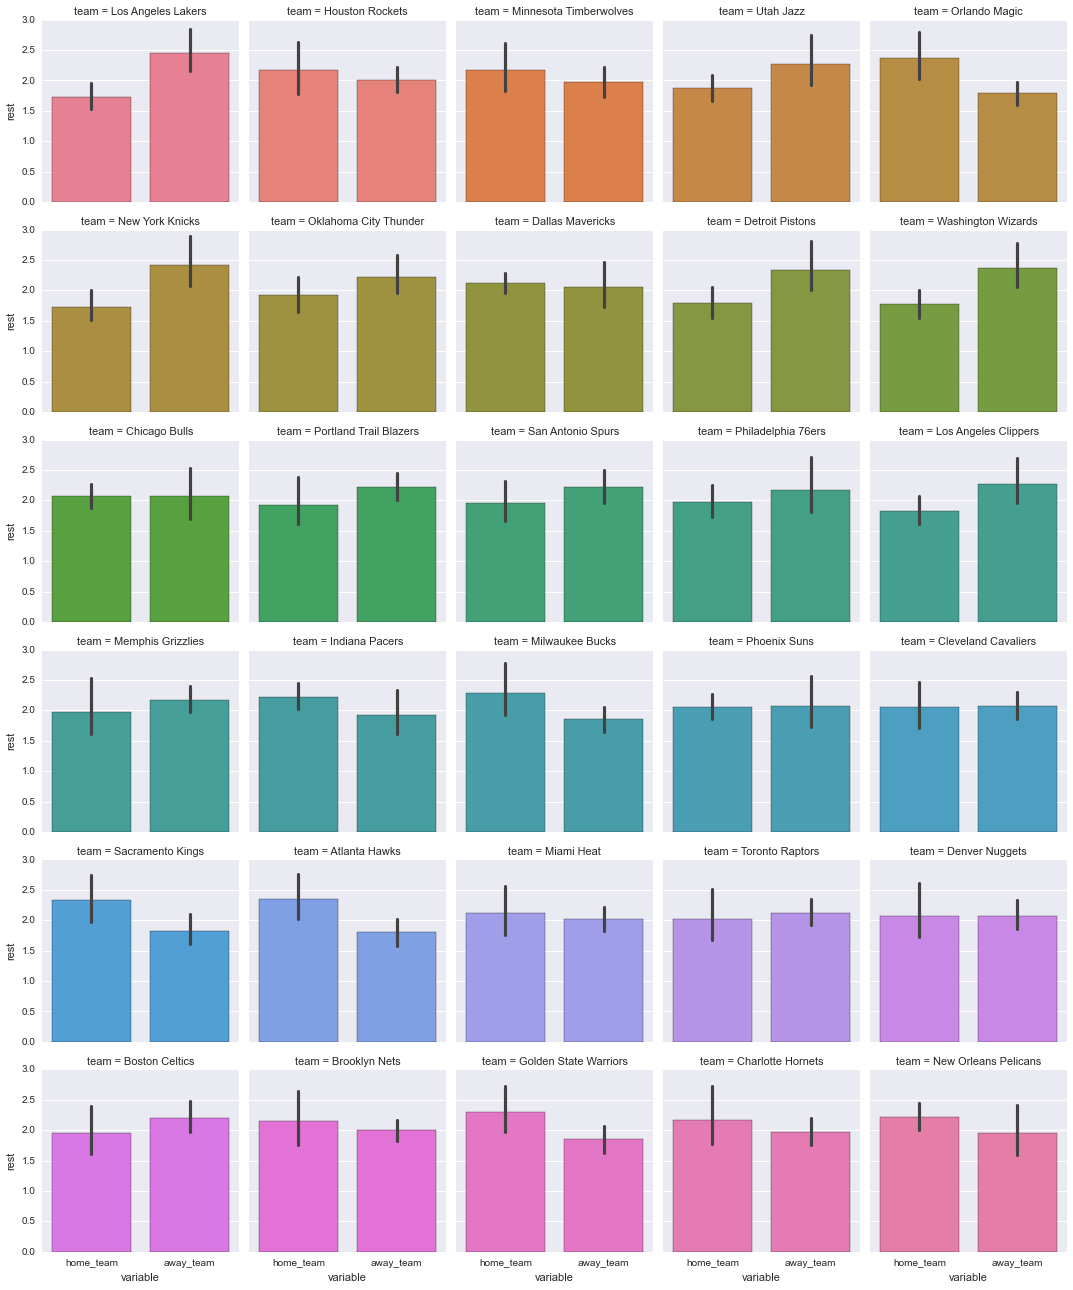

In [46]:
g = sns.FacetGrid(data=tidy.dropna(), col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest");

# Stack / Unstack

An "observation" depends on the question. Home team advantage?

Home win percent: 0.574796747967


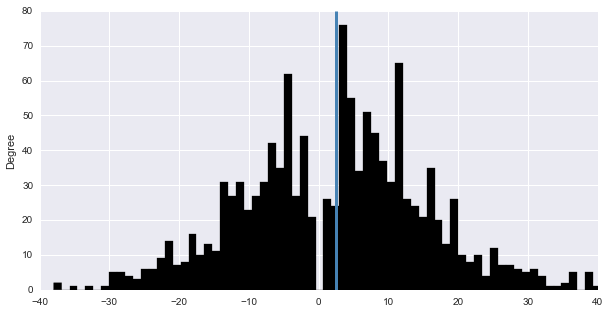

In [47]:
home_adv = games.home_points - games.away_points
ax = (home_adv).plot(kind='hist', bins=80, color='k', figsize=(10, 5))
ax.set_xlim(-40, 40)
mu = home_adv.mean()
ax.vlines(mu, *ax.get_ylim(), color='steelblue', linewidth=3)
print('Home win percent:', (home_adv > 0).mean())

In [48]:
games['home_win'] = games.home_points > games.away_points
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


In [49]:
games.groupby('away_team').home_win.mean()

away_team
Atlanta Hawks         0.390244
Boston Celtics        0.536585
Brooklyn Nets         0.536585
Charlotte Hornets     0.658537
Chicago Bulls         0.439024
                        ...   
Sacramento Kings      0.731707
San Antonio Spurs     0.463415
Toronto Raptors       0.463415
Utah Jazz             0.585366
Washington Wizards    0.585366
Name: home_win, dtype: float64

In [51]:
wins_as_away = games.groupby('away_team').home_win.agg(
    {'n_games': 'count', 'n_wins': lambda x: (~x).sum()}
)
wins_as_home = games.groupby('home_team').home_win.agg(
    {'n_games': 'count', 'n_wins': 'sum'}
)

In [52]:
x = games.groupby('away_team').get_group('Golden State Warriors')
(~x.home_win).mean()

0.68292682926829273

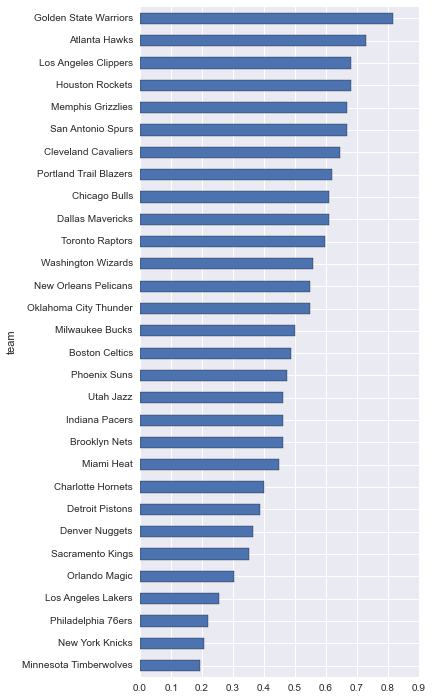

In [53]:
wins = (wins_as_away + wins_as_home)
strength = wins.n_wins / wins.n_games
strength.index.name = 'team'
strength.name = 'strength'
strength.order().plot(kind='barh', figsize=(5, 12))

Bring the `strength` valuess in for each team, for each game.

In [54]:
strength.head()

team
Atlanta Hawks        0.731707
Boston Celtics       0.487805
Brooklyn Nets        0.463415
Charlotte Hornets    0.402439
Chicago Bulls        0.609756
Name: strength, dtype: float64

In [55]:
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


For SQL people

In [57]:
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


In [63]:
strength.head().reset_index().rename(columns=lambda x: 'away_' + x)

,away_team,away_strength
0,Atlanta Hawks,0.731707
1,Boston Celtics,0.487805
2,Brooklyn Nets,0.463415
3,Charlotte Hornets,0.402439
4,Chicago Bulls,0.609756


In [237]:
(pd.merge(games.reset_index(), strength.reset_index().add_prefix('away_'))
   .pipe(pd.merge, strength.reset_index().add_prefix('home_'))
   .set_index(['game_id', 'date']))

,,away_team,away_points,home_team,home_points,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False,0.682927,0.256098
661,2015-01-25,Houston Rockets,99,Los Angeles Lakers,87,False,0.682927,0.256098
541,2015-01-09,Orlando Magic,84,Los Angeles Lakers,101,True,0.304878,0.256098
932,2015-03-08,Dallas Mavericks,100,Los Angeles Lakers,93,False,0.609756,0.256098
1197,2015-04-12,Dallas Mavericks,120,Los Angeles Lakers,106,False,0.609756,0.256098
...,...,...,...,...,...,...,...,...
214,2014-11-26,Sacramento Kings,89,Houston Rockets,102,True,0.353659,0.682927
1112,2015-04-01,Sacramento Kings,111,Houston Rockets,115,True,0.353659,0.682927
476,2014-12-31,Charlotte Hornets,83,Houston Rockets,102,True,0.402439,0.682927


For python people

In [65]:
games = games.assign(away_strength=games.away_team.map(strength),
                     home_strength=games.home_team.map(strength))
games.head()

,,away_team,away_points,home_team,home_points,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False,0.682927,0.256098
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True,0.304878,0.548780
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True,0.609756,0.670732
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True,0.463415,0.487805
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True,0.500000,0.402439


In [66]:
X = pd.concat([games, un], axis=1).set_index(['away_team', 'home_team'], append=True).dropna()

In [67]:
X.head()

,,,,away_points,home_points,home_win,away_strength,home_strength,away_rest,home_rest
game_id,date,away_team,home_team,,,,,,,
16,2014-10-30,Utah Jazz,Dallas Mavericks,102,120,True,0.463415,0.609756,1,2
18,2014-10-30,Detroit Pistons,Minnesota Timberwolves,91,97,True,0.390244,0.195122,1,1
19,2014-10-30,Washington Wizards,Orlando Magic,105,98,False,0.560976,0.304878,1,2
20,2014-10-31,Cleveland Cavaliers,Chicago Bulls,114,108,False,0.646341,0.609756,1,2
21,2014-10-31,Memphis Grizzlies,Indiana Pacers,97,89,False,0.670732,0.463415,2,2


In [68]:
X['home_win'] = X.home_win.astype(int)

In [70]:
import statsmodels.api as sm

In [71]:
mod = sm.Logit.from_formula('home_win ~ home_strength + away_strength + home_rest + away_rest', X)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.564564
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1208
Method:                           MLE   Df Model:                            4
Date:                Sat, 18 Jul 2015   Pseudo R-squ.:                  0.1728
Time:                        21:07:17   Log-Likelihood:                -684.82
converged:                       True   LL-Null:                       -827.83
                                        LLR p-value:                 1.120e-60
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -0.4620      0.326     -1.419      0.156        -1.100     0.176
home_strength     5.5604      0.449     12.389      0.000         4.681     6.440
away_strength    -4.3474      0.442     -9.835      0.000        -5.214    -3.481
home_rest         0.1327      0.069      1.913      0.056        -0.003     0.269
away_rest        -0.0345      0.066     -0.526      0.599        -0.163     0.094
=================================================================================
"""

In [72]:
mod = sm.Logit.from_formula('home_win ~ rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest))
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.682125
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1211
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Jul 2015   Pseudo R-squ.:               0.0004950
Time:                        21:07:19   Log-Likelihood:                -827.42
converged:                       True   LL-Null:                       -827.83
                                        LLR p-value:                    0.3653
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.2815      0.060      4.721      0.000         0.165     0.398
rest_difference     0.0473      0.052      0.903      0.366        -0.055     0.150
===================================================================================
"""

In [136]:
mod = sm.OLS.from_formula('spread ~ home_strength + away_strength + rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest,
                                     spread=lambda df: df.home_points - df.away_points))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     127.7
Date:                Sat, 18 Jul 2015   Prob (F-statistic):           5.56e-72
Time:                        09:04:26   Log-Likelihood:                -4776.2
No. Observations:                1230   AIC:                             9560.
Df Residuals:                    1226   BIC:                             9581.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.2877      1.532     -0.188      0.851        -3.293     2.718
home_strength      30.7402      2.082     14.766      0.000        26.656    34.825
away_strength     -25.6633      2.082    -12.328      0.000       -29.747   -21.579
rest_difference     0.6016      0.303      1.987      0.047         0.008     1.196
==============================================================================
Omnibus:                        9.454   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.813
Skew:                           0.102   Prob(JB):                      0.00272
Kurtosis:                       3.435   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Other reshaping operations

- stack
- unstack

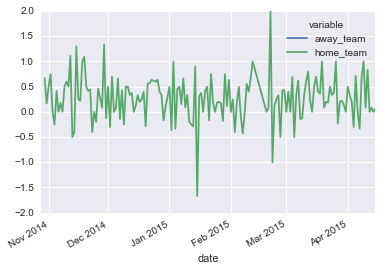

In [73]:
tidy.groupby(['date', 'variable']).rest.mean().unstack().diff(axis=1).plot()

In [74]:
tidy.groupby(['date', 'variable']).rest.mean().unstack().stack()

date        variable 
2014-10-29  away_team    1.000000
2014-10-30  away_team    1.000000
            home_team    1.666667
2014-10-31  away_team    1.833333
            home_team    2.000000
                           ...   
2015-04-13  home_team    1.500000
2015-04-14  away_team    2.000000
            home_team    2.000000
2015-04-15  away_team    1.857143
            home_team    1.928571
dtype: float64

In [75]:
# Which date had the most in favor of home...
# argmax

In [76]:
tidy.groupby(['date', 'variable']).rest.sum().unstack().diff(axis=1).home_team.idxmax()

Timestamp('2014-11-15 00:00:00')

In [77]:
tidy.groupby(['date', 'variable']).rest.sum().unstack().diff(axis=1).home_team.idxmin()

Timestamp('2015-02-22 00:00:00')